<a href="https://colab.research.google.com/github/baker-jr-john/automated-summary-evaluation-llm/blob/main/04_LLM_Evaluation_Results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### CELL 1: Setup & Installation



In [1]:
!pip install bitsandbytes

print("✅ Packages installed")

✅ Packages installed


### CELL 2: Imports

In [2]:
import pandas as pd
import numpy as np
import json
import re
from datetime import datetime
from sklearn.metrics import cohen_kappa_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from huggingface_hub import login
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch
import os
import shutil
from google.colab import drive, files, userdata
drive.mount('/content/drive')

print("✅ Imports complete")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Imports complete


### CELL 3: Ground Truth Scores

In [3]:
# From Summary_Scoring_Template.xlsx

GROUND_TRUTH = {
    'VAL_01': {'completeness': 4, 'accuracy': 5, 'coherence': 5, 'conciseness': 4},
    'VAL_02': {'completeness': 4, 'accuracy': 4, 'coherence': 3, 'conciseness': 3},
    'VAL_03': {'completeness': 2, 'accuracy': 4, 'coherence': 3, 'conciseness': 4},
    'VAL_04': {'completeness': 4, 'accuracy': 4, 'coherence': 4, 'conciseness': 3},
    'VAL_05': {'completeness': 4, 'accuracy': 4, 'coherence': 4, 'conciseness': 4},
    'VAL_06': {'completeness': 4, 'accuracy': 4, 'coherence': 4, 'conciseness': 4},
    'VAL_07': {'completeness': 3, 'accuracy': 3, 'coherence': 4, 'conciseness': 4},
    'VAL_08': {'completeness': 3, 'accuracy': 3, 'coherence': 3, 'conciseness': 4},
    'VAL_09': {'completeness': 4, 'accuracy': 4, 'coherence': 3, 'conciseness': 4},
    'VAL_10': {'completeness': 4, 'accuracy': 5, 'coherence': 5, 'conciseness': 4},
    'VAL_11': {'completeness': 4, 'accuracy': 5, 'coherence': 4, 'conciseness': 4},
    'VAL_12': {'completeness': 4, 'accuracy': 4, 'coherence': 4, 'conciseness': 4},
    'VAL_13': {'completeness': 2, 'accuracy': 2, 'coherence': 2, 'conciseness': 2},
    'VAL_14': {'completeness': 2, 'accuracy': 3, 'coherence': 3, 'conciseness': 4},
    'VAL_15': {'completeness': 3, 'accuracy': 4, 'coherence': 4, 'conciseness': 4},
    'VAL_16': {'completeness': 4, 'accuracy': 3, 'coherence': 4, 'conciseness': 5},
    'VAL_17': {'completeness': 4, 'accuracy': 5, 'coherence': 5, 'conciseness': 5},
    'VAL_18': {'completeness': 4, 'accuracy': 4, 'coherence': 4, 'conciseness': 3},
    'VAL_19': {'completeness': 3, 'accuracy': 4, 'coherence': 4, 'conciseness': 4},
    'VAL_20': {'completeness': 4, 'accuracy': 5, 'coherence': 4, 'conciseness': 2},
    'VAL_21': {'completeness': 2, 'accuracy': 2, 'coherence': 2, 'conciseness': 2},
    'VAL_22': {'completeness': 2, 'accuracy': 3, 'coherence': 3, 'conciseness': 4},
    'VAL_23': {'completeness': 4, 'accuracy': 4, 'coherence': 4, 'conciseness': 4},
    'VAL_24': {'completeness': 4, 'accuracy': 3, 'coherence': 4, 'conciseness': 3},
    'VAL_25': {'completeness': 2, 'accuracy': 3, 'coherence': 3, 'conciseness': 3},
}

print(f"✅ Loaded ground truth for {len(GROUND_TRUTH)} summaries")

# Display distribution
gt_df = pd.DataFrame(GROUND_TRUTH).T
print("\nGround Truth Score Distribution:")
print(gt_df.describe().round(2))

✅ Loaded ground truth for 25 summaries

Ground Truth Score Distribution:
       completeness  accuracy  coherence  conciseness
count         25.00     25.00      25.00        25.00
mean           3.36      3.76       3.68         3.64
std            0.86      0.88       0.80         0.81
min            2.00      2.00       2.00         2.00
25%            3.00      3.00       3.00         3.00
50%            4.00      4.00       4.00         4.00
75%            4.00      4.00       4.00         4.00
max            4.00      5.00       5.00         5.00


### CELL 4: Load Validation Summaries

In [4]:
VALIDATION_CSV_PATH = '/content/drive/MyDrive/Courses/2025/3_Fall/EDUC_6192_Large_Language_Model_Applications_in_Education/Project/Phase_1/data/dataset/validation_set_combined_60.csv'

print(f"Loading data from: {VALIDATION_CSV_PATH}")

try:
    validation_df = pd.read_csv(VALIDATION_CSV_PATH)

    print(f"\n✅ Loaded {len(validation_df)} summaries from CSV")
    print(f"Columns: {list(validation_df.columns)}")
    print("\nFirst 3 rows:")
    display(validation_df.head(3))

except Exception as e:
    print(f"\nCRITICAL ERROR: Could not read the file. Python returned: {e}")

Loading data from: /content/drive/MyDrive/Courses/2025/3_Fall/EDUC_6192_Large_Language_Model_Applications_in_Education/Project/Phase_1/data/dataset/validation_set_combined_60.csv

✅ Loaded 60 summaries from CSV
Columns: ['essay_id', 'score', 'full_text', 'assignment', 'prompt_name', 'economically_disadvantaged', 'student_disability_status', 'ell_status', 'race_ethnicity', 'gender', 'source_text_1', 'source_text_2', 'source_text_3', 'source_text_4', 'synthetic_flag', 'target_error_pattern', 'generation_date', 'generation_model', 'word_count']

First 3 rows:


,essay_id,score,full_text,assignment,prompt_name,economically_disadvantaged,student_disability_status,ell_status,race_ethnicity,gender,source_text_1,source_text_2,source_text_3,source_text_4,synthetic_flag,target_error_pattern,generation_date,generation_model,word_count
0,AAAVUP14319000017665,1,Exploring Venus some people think that we shou...,"In ""The Challenge of Exploring Venus,"" the aut...",Exploring Venus,Economically disadvantaged,Not identified as having disability,Yes,Hispanic/Latino,F,"The Challenge of Exploring Venus\nVenus, somet...",NaN,NaN,NaN,False,Authentic student work,NaN,NaN,387
1,AAAVUP14319000153727,2,This history is about Venus. NASA is trying to...,"In ""The Challenge of Exploring Venus,"" the aut...",Exploring Venus,Economically disadvantaged,Not identified as having disability,Yes,Hispanic/Latino,M,"The Challenge of Exploring Venus\nVenus, somet...",NaN,NaN,NaN,False,Authentic student work,NaN,NaN,286
2,AAAVUP14319000070539,6,People are facinated with the Man on the Moon ...,"In ""The Challenge of Exploring Venus,"" the aut...",Exploring Venus,Not economically disadvantaged,Not identified as having disability,No,White,F,"The Challenge of Exploring Venus\nVenus, somet...",NaN,NaN,NaN,False,Authentic student work,NaN,NaN,753


### CELL 5: Map VAL_XX IDs to essay_ids in the CSV

In [5]:
VAL_TO_ESSAY_ID = {
    'VAL_01': 'SYNTH_V_08_S2',
    'VAL_02': 'AAAVUP14319000151934',
    'VAL_03': 'AAAVUP14319000020038',
    'VAL_04': 'AAAVUP14319000033223',
    'VAL_05': 'SYNTH_V_18_S3',
    'VAL_06': 'SYNTH_V_06_S2',
    'VAL_07': 'SYNTH_V_13_S3',
    'VAL_08': 'AAAVUP14319000100017',
    'VAL_09': 'AAAVUP14319000017185',
    'VAL_10': 'SYNTH_V_07_S2',
    'VAL_11': 'AAAVUP14319000017665',
    'VAL_12': 'AAAVUP14319000040359',
    'VAL_13': 'AAAVUP14319000090737',
    'VAL_14': 'AAAVUP14319000153727',
    'VAL_15': 'SYNTH_V_09_S2',
    'VAL_16': 'SYNTH_V_21_S4',
    'VAL_17': 'SYNTH_V_17_S3',
    'VAL_18': 'AAAVUP14319000111046',
    'VAL_19': 'SYNTH_V_16_S3',
    'VAL_20': 'AAAVUP14319000070539',
    'VAL_21': 'AAAVUP14319000102747',
    'VAL_22': 'AAAVUP14319000090338',
    'VAL_23': 'SYNTH_V_12_S3',
    'VAL_24': 'AAAVUP14319000102110',
    'VAL_25': 'AAAVUP14319000051516',
}

# Build summaries dictionary
SUMMARIES = {}
for val_id, essay_id in VAL_TO_ESSAY_ID.items():
    row = validation_df[validation_df['essay_id'] == essay_id]
    if len(row) > 0:
        SUMMARIES[val_id] = row['full_text'].values[0]
    else:
        print(f"WARNING: {essay_id} not found in CSV for {val_id}")

print(f"✅ Loaded {len(SUMMARIES)} summaries")

✅ Loaded 25 summaries


### CELL 6: Load Model

In [ ]:
# Login to HuggingFace
try:
    HF_TOKEN = userdata.get('HF_TOKEN')
    login(token=HF_TOKEN)
    print("✓ Authenticated with Hugging Face (via Secrets)")
except Exception:
    print("Secret not found. Please enter your Hugging Face token manually:")
    login()
    print("✅ Authenticated with Hugging Face (manual entry)")

MODEL_NAME = "meta-llama/Llama-3.1-8B-Instruct"

# 4-bit quantization config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"
)

print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token

print("Loading model (this takes 2-3 minutes)...")
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    device_map="auto",
    torch_dtype=torch.float16
)

print("✅ Model loaded successfully!")

### CELL 7: Source Text and Evaluation Logic

In [16]:
SOURCE_TEXT = """THE CHALLENGE OF EXPLORING VENUS

Venus, sometimes called the "Evening Star," is one of the brightest points of light in the night sky, making it simple for even an amateur stargazer to spot. However, this nickname is misleading since Venus is actually a planet. While Venus is simple to see from the distant but safe vantage point of Earth, it has proved a very challenging place to examine more closely.

Often referred to as Earth's "twin," Venus is the closest planet to Earth in terms of density and size, and occasionally the closest in distance too. Earth and Venus, along with Mars, our other planetary neighbor, orbit the sun at different speeds. These differences in speed mean that sometimes we are closer to Mars and other times to Venus. Because Venus is sometimes right around the corner—in space terms—humans have sent numerous spacecraft to land on this cloud-draped world. Each previous mission was unmanned, and for good reason, since no spacecraft survived the landing for more than a few hours. Maybe this issue explains why not a single spaceship has touched down on Venus in more than three decades. Numerous factors contribute to Venus's reputation as a challenging planet for humans to study, despite its proximity to us.

A thick atmosphere of almost 97 percent carbon dioxide blankets Venus. Even more challenging are the clouds of highly corrosive sulfuric acid in Venus's atmosphere. On the planet's surface, temperatures average over 800 degrees Fahrenheit, and the atmospheric pressure is 90 times greater than what we experience on our own planet. These conditions are far more extreme than anything humans encounter on Earth; such an environment would crush even a submarine accustomed to diving to the deepest parts of our oceans and would liquefy many metals. Also notable, Venus has the hottest surface temperature of any planet in our solar system, even though Mercury is closer to our sun. Beyond high pressure and heat, Venusian geology and weather present additional impediments like erupting volcanoes, powerful earthquakes, and frequent lightning strikes to probes seeking to land on its surface.

If our sister is so inhospitable, why are scientists even discussing further visits to its surface? Astronomers are fascinated by Venus because it may well once have been the most Earth-like planet in our solar system. Long ago, Venus was probably covered largely with oceans and could have supported various forms of life, just like Earth. Today, Venus still has some features that are analogous to those on Earth. The planet has a surface of rocky sediment and includes familiar features such as valleys, mountains, and craters. Furthermore, recall that Venus can sometimes be our nearest option for a planetary visit, a crucial consideration given the long time frames of space travel. The value of returning to Venus seems indisputable, but what are the options for making such a mission both safe and scientifically productive?

The National Aeronautics and Space Administration (NASA) has one particularly compelling idea for sending humans to study Venus. NASA's possible solution to the hostile conditions on the surface of Venus would allow scientists to float above the fray. Imagine a blimp-like vehicle hovering 30 or so miles above the roiling Venusian landscape. Just as our jet airplanes travel at a higher altitude to fly over many storms, a vehicle hovering over Venus would avoid the unfriendly ground conditions by staying up and out of the way. At thirty-plus miles above the surface, temperatures would still be toasty at around 170 degrees Fahrenheit, but the air pressure would be close to that of sea level on Earth. Solar power would be plentiful, and radiation would not exceed Earth's levels. Not easy conditions, but survivable for humans.

However, peering at Venus from a ship orbiting or hovering safely far above the planet can provide only limited insight into ground conditions, rendering standard forms of photography and videography ineffective. More importantly, researchers cannot take samples of rock, gas, or anything else from a distance. Therefore, scientists seeking to conduct a thorough mission to understand Venus would need to get up close and personal despite the risks. Or maybe we should think of them as challenges. Many researchers are working on innovations that would allow our machines to last long enough to contribute meaningfully to our knowledge of Venus.

NASA is working on other approaches to studying Venus. For example, some simplified electronics made of silicon carbide have been tested in a chamber simulating the chaos of Venus's surface and have lasted for three weeks in such conditions. Another project is looking back at an old technology called mechanical computers. These devices were first envisioned in the 1800s and played an important role in the 1940s during World War II. The thought of computers existing in those days may sound shocking, but these devices made calculations by using gears and levers and did not require electronics at all. Modern computers are enormously powerful, flexible, and quick, but tend to be more delicate when it comes to extreme physical conditions. Just imagine exposing a cell phone or tablet to acid or heat capable of melting tin. By comparison, systems that use mechanical parts can be made more resistant to pressure, heat, and other forces.

Striving to meet the challenge presented by Venus has value, not only because of the insight to be gained on the planet itself, but also because human curiosity will likely lead us into many equally intimidating endeavors. Our travels on Earth and beyond should not be limited by dangers and doubts but should be expanded to meet the very edges of imagination and innovation."""

print("✅ Source text loaded")

def create_evaluation_messages(summary, source_text=SOURCE_TEXT):
    # 1. Define Exemplar 1 (True Score 5 - The "Gold Standard")
    exemplar_summary = """In “The Challenge of Exploring Venus,” the author explains why Venus is both extremely difficult to explore and still an important target for future missions. Although Venus looks like a bright “Evening Star” in our sky and is often Earth’s closest planetary neighbor, past unmanned landers have survived only a few hours on its surface, and none have landed there in more than thirty years. The planet is wrapped in an atmosphere that is nearly 97 percent carbon dioxide with clouds of sulfuric acid. On the surface, temperatures rise above 800°F, the pressure is about 90 times that of Earth, and erupting volcanoes, strong earthquakes, and frequent lightning strikes make it the hottest and one of the most hostile places in the solar system.

Despite these dangers, scientists believe Venus may once have had oceans and conditions similar to Earth’s and still has familiar features like rocky ground, mountains, valleys, and craters. Because Venus is relatively close by, studying it can help us understand how planets change over time, including our own. NASA is exploring several ideas to make this possible. One proposal is to use a blimp-like vehicle that would float about 30 miles above the surface, where the temperature (around 170°F) and air pressure are closer to those at sea level on Earth, sunlight is plentiful, and radiation levels are similar to ours. However, observing from high above cannot collect samples, so engineers are also creating technology that can survive on the ground, such as silicon carbide electronics that have lasted for three weeks in Venus-like test chambers and tough mechanical computers that can handle intense heat and pressure better than delicate modern electronics. The author concludes that solving the problems of exploring Venus will not only deepen our knowledge of that planet but also push human curiosity and innovation to take on other intimidating challenges."""

    exemplar_evaluation = """
Completeness Analysis: The summary is comprehensive. It covers all key dimensions: the specific dangers (temperature/pressure/acid), the scientific value (Earth's twin/past oceans), and BOTH types of solutions: NASA's hovering blimps AND the surface-level tech (silicon carbide/mechanical computers). Nothing major is omitted.
Completeness Score: 5
Accuracy Analysis: All facts are precise and align perfectly with the text (e.g., 97% CO2, 30 miles altitude, silicon carbide longevity).
Accuracy Score: 5
Coherence Analysis: The response flows logically from the problem (dangers) to the motivation (value) to the solutions. Transitions like "Despite these dangers" and "However" effectively bridge ideas.
Coherence Score: 5
Conciseness Analysis: The writing is dense and efficient. It combines related details into single, fluid sentences without unnecessary repetition.
Conciseness Score: 5
"""

    # 2. Define Exemplar 2 (Anchor for Score 3 - Authentic Student Response)
    # [This remains the same as your original notebook to show the "average" baseline]
    anchor_summary = """This history is about Venus. NASA is trying to go to the planet call Venus because is the planet that look just like Earth.
They want to go because they want to show how Venus look like. So people can go live in Venus, but NASA don't want to send people because is so danger.
In the solar system Venus is the second plane from the sun.
Venus is call the "Evening Star" because it is the brightest point of light in the night sky.
It is the twin planet of the Earth because it have the same side of the Earth, and in distance is the closed plane that Earth have.
"Each previous mission was unmanned, and good reason, since no spacecraft survived the landing for more than a few hours.
Venus have 97 percent carbon dioxide blankets. On other planets the temperature average is about 800 degrees Fahrenheit, and the atmospheric is abuot 90 times greater than what we experience.
"Also Venus have the hottest surface temperature of any planet in our solar system, even Mecury is closer to our sun.
Long time ago Venus was probably covered by ocean and could have supported varius forms of life, just like Earth.
NASA is trying to make mechanical computer the ones that help a lot in WW II, so they don't have to used people, but they have to use more tegnology.
In conclution that is a good idea because human need more space to live and some people like the idea to explor what is outside the Earth.
"Our travels on Earth and beyond should not be limited by dangers and doubts but be expanded to meet the very edges of imagination and innovation"."""

    anchor_evaluation = """
Completeness Analysis: Identifies dangers (heat, CO2), value (twin, ocean), and solutions (mechanical computer). However, the explanation of solutions is vague ("use more tegnology") and misses the blimp concept entirely.
Completeness Score: 2
Accuracy Analysis: Most facts are correct (97%, 800 degrees, 90x pressure), but contains grammatical inaccuracies that slightly obscure meaning ("same side of the Earth").
Accuracy Score: 3
Coherence Analysis: Organized as a list of facts rather than a flowing essay. Transitions are weak or missing. However, ideas are grouped somewhat logically.
Coherence Score: 3
Conciseness Analysis: Includes some repetition and unnecessary quotes, but length is generally appropriate.
Conciseness Score: 4
"""

    # 3. Construct the System Prompt
    system_content = f"""You are a supportive, encouraging Middle School English teacher.
    Your goal is to evaluate student summaries based on the provided rubric.

    CALIBRATION INSTRUCTIONS:
    1. ADJUST FOR GRADE LEVEL: These are 6th-8th graders. A summary does NOT need to be perfect to earn a 5.
    2. SCORE DISTRIBUTION:
       - 5 (Advanced): Strong grasp of main ideas. Includes ALL key points (Dangers, Value, Blimps, Surface Tech).
       - 4 (Proficient): Good summary. Captures most points but might miss one detail (like the mechanical computers).
       - 3 (Developing): Captures the gist but misses details.
       - 2 (Emerging): Significant gaps.
       - 1 (Beginning): Barely related.
    3. BIAS CORRECTION: You have a tendency to be too harsh. If you are debating between two scores (e.g., 3 and 4), ALWAYS CHOOSE THE HIGHER SCORE.

    SOURCE TEXT:
    {source_text}

    RUBRIC:
    COMPLETENESS (1-5):
    5=Comprehensive. Covers ALL 3 main topics: Dangers, Value, and Solutions (both blimps and surface tech).
    4=Detailed but misses one minor aspect.
    3=Adequate. Covers the gist of the main ideas. May lack specific details but captures the big picture.
    2=Incomplete. Misses entire sections or key concepts.
    1=Barely touches the text.

    ACCURACY (1-5):
    5=Perfectly accurate.
    4=Minor details off (e.g., wrong specific number) but main points correct.
    3=Generally accurate but contains some misunderstandings or errors.
    2=Multiple major factual errors.
    1=Completely wrong or fabricated.

    COHERENCE (1-5):
    5=Smooth flow, sophisticated transitions.
    4=Clear organization, basic transitions used correctly.
    3=Functional organization. Ideas are grouped. Standard/repetitive transitions (e.g., "First, Next") are ACCEPTABLE for a score of 3.
    2=Confusing ordering or disjointed sentences.
    1=Incoherent word salad.

    CONCISENESS (1-5):
    5=Efficient. (Note: A long summary can still be a 5 if it is detailed and not repetitive).
    4=Good, occasional extra words.
    3=Wordy. Contains clear redundancy.
    2=Significantly repetitive or wandering.
    1=Severe rambling that obscures meaning.

    ---
    INSTRUCTIONS:
    1. ANALYSIS FIRST: Explain your reasoning for each dimension BEFORE assigning a score.
    2. BIAS CHECK: Remember that these are 6th-8th graders. "List-like" writing is often a 3 or 4 in Coherence, not a 2. Minor wordiness is a 3 or 4 in Conciseness, not a 1.
    3. FORMAT: Use this EXACT structure:

    Completeness Analysis: <reasoning>
    Completeness Score: <number>
    Accuracy Analysis: <reasoning>
    Accuracy Score: <number>
    Coherence Analysis: <reasoning>
    Coherence Score: <number>
    Conciseness Analysis: <reasoning>
    Conciseness Score: <number>

    ### REFERENCE EXAMPLE 1 (Score 5 / Advanced)
    STUDENT SUMMARY:
    {exemplar_summary}

    YOUR EVALUATION:
    {exemplar_evaluation}

    ### REFERENCE EXAMPLE 2 (Score 3 / Developing)
    STUDENT SUMMARY:
    {anchor_summary}

    YOUR EVALUATION:
    {anchor_evaluation}

    --
    INSTRUCTIONS:
    1. Compare the new summary to the Source Text and the Reference Examples.
    2. If the new summary is of similar quality to a reference, assign similar scores.
    3. Be objective and avoid being overly harsh.
    """

    user_content = f"""STUDENT SUMMARY:
{summary}

YOUR EVALUATION:"""

    messages = [
        {"role": "system", "content": system_content},
        {"role": "user", "content": user_content}
    ]

    return messages

print("✅ Optimization: Chain-of-Thought Prompt Template defined")

✅ Source text loaded
✅ Optimization: Chain-of-Thought Prompt Template defined


### CELL 8: Parse Scores from LLM Response

In [17]:
def parse_scores(text):
    """
    Parses the new "Analysis First" format.
    """
    # Default values
    scores = {
        'completeness_score': 0, 'completeness_feedback': "Error parsing",
        'accuracy_score': 0, 'accuracy_feedback': "Error parsing",
        'coherence_score': 0, 'coherence_feedback': "Error parsing",
        'conciseness_score': 0, 'conciseness_feedback': "Error parsing"
    }

    if "YOUR EVALUATION:" in text:
        text = text.split("YOUR EVALUATION:")[-1]

    # The keys we look for in the LLM output
    # Note: We map "Analysis" in output to "feedback" in our dataframe
    dimensions = ["Completeness", "Accuracy", "Coherence", "Conciseness"]

    for dim in dimensions:
        # Regex to capture the block: "Completeness Analysis: (.*?) Completeness Score: (\d)"
        # This looks for the Analysis text up until the word "Score" comes up
        analysis_pattern = rf"{dim} Analysis:(.*?){dim} Score:"
        score_pattern = rf"{dim} Score:\s*(\d)"

        # Extract Analysis (Feedback)
        analysis_match = re.search(analysis_pattern, text, re.DOTALL | re.IGNORECASE)
        if analysis_match:
            feedback_text = analysis_match.group(1).strip()
            # Cleanup chatty endings
            for stop in ["Note:", "---"]:
                if stop in feedback_text:
                    feedback_text = feedback_text.split(stop)[0].strip()

            scores[f"{dim.lower()}_feedback"] = feedback_text

        # Extract Score
        score_match = re.search(score_pattern, text, re.IGNORECASE)
        if score_match:
            scores[f"{dim.lower()}_score"] = int(score_match.group(1))

    return scores

print("✅ Optimization: CoT Parser defined")

✅ Optimization: CoT Parser defined


### CELL 9: Run Full Evaluation

In [18]:
def generate_evaluation(summary_text):
    # 1. Create Messages (using the function from Cell 7)
    messages = create_evaluation_messages(summary_text)

    # 2. Tokenize
    input_ids = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        return_tensors="pt"
    ).to(model.device)

    # 3. Generate (Parameters matched to Live Demo for consistency)
    with torch.no_grad():
        outputs = model.generate(
            input_ids,
            max_new_tokens=600,      # Matched to Demo
            temperature=0.1,         # Matched to Demo (Low temp for consistency)
            do_sample=True,
            top_p=0.95,
            pad_token_id=tokenizer.eos_token_id
        )

    # 4. Decode
    response = tokenizer.decode(outputs[0][input_ids.shape[1]:], skip_special_tokens=True)
    return response

# --- MAIN EXECUTION LOOP ---
print("="*70)
print("RUNNING FULL VALIDATION")
print("="*70)

results = []

for i, (val_id, summary_text) in enumerate(SUMMARIES.items(), 1):
    print(f"\n[{i}/{len(SUMMARIES)}] Evaluating {val_id}...")

    try:
        # A. Generate & Parse
        response = generate_evaluation(summary_text)
        llm_data = parse_scores(response) # Returns flat dict with scores AND feedback

        # B. Get Ground Truth
        gt_data = GROUND_TRUTH[val_id]

        # C. Build Result Row (Combining everything)
        row = {
            'summary_id': val_id,
            'essay_id': VAL_TO_ESSAY_ID[val_id],
            'full_response': response # Save raw response for debugging
        }

        # Add LLM Scores & Feedback
        row.update(llm_data)

        # Add Ground Truth Scores
        for dim in ['completeness', 'accuracy', 'coherence', 'conciseness']:
            row[f'gt_{dim}'] = gt_data[dim]

        results.append(row)

        # D. Live Console Comparison
        # Note: We must match llm_data keys (e.g. 'completeness_score') to gt keys ('completeness')
        for dim in ['completeness', 'accuracy', 'coherence', 'conciseness']:
            llm_val = llm_data.get(f'{dim}_score', 0)
            gt_val = gt_data[dim]

            # Visual check marks
            if llm_val == gt_val:
                match = "✓"
            elif abs(llm_val - gt_val) == 1:
                match = "○"
            else:
                match = "✗"

            print(f"  {dim.capitalize()}: LLM={llm_val} GT={gt_val} {match}")

    except Exception as e:
        print(f"  ERROR processing {val_id}: {e}")

# Save to DataFrame immediately
results_df = pd.DataFrame(results)

print("\n" + "="*70)
print(f"✅ Completed evaluation of {len(results_df)} summaries")
print("="*70)

# Display first few rows to confirm structure
display(results_df.head(3))

RUNNING FULL VALIDATION

[1/25] Evaluating VAL_01...
  Completeness: LLM=3 GT=4 ○
  Accuracy: LLM=3 GT=5 ✗
  Coherence: LLM=3 GT=5 ✗
  Conciseness: LLM=4 GT=4 ✓

[2/25] Evaluating VAL_02...
  Completeness: LLM=3 GT=4 ○
  Accuracy: LLM=3 GT=4 ○
  Coherence: LLM=2 GT=3 ○
  Conciseness: LLM=3 GT=3 ✓

[3/25] Evaluating VAL_03...
  Completeness: LLM=3 GT=2 ○
  Accuracy: LLM=2 GT=4 ✗
  Coherence: LLM=3 GT=3 ✓
  Conciseness: LLM=3 GT=4 ○

[4/25] Evaluating VAL_04...
  Completeness: LLM=3 GT=4 ○
  Accuracy: LLM=3 GT=4 ○
  Coherence: LLM=3 GT=4 ○
  Conciseness: LLM=3 GT=3 ✓

[5/25] Evaluating VAL_05...
  Completeness: LLM=3 GT=4 ○
  Accuracy: LLM=4 GT=4 ✓
  Coherence: LLM=4 GT=4 ✓
  Conciseness: LLM=4 GT=4 ✓

[6/25] Evaluating VAL_06...
  Completeness: LLM=4 GT=4 ✓
  Accuracy: LLM=4 GT=4 ✓
  Coherence: LLM=4 GT=4 ✓
  Conciseness: LLM=4 GT=4 ✓

[7/25] Evaluating VAL_07...
  Completeness: LLM=3 GT=3 ✓
  Accuracy: LLM=3 GT=3 ✓
  Coherence: LLM=4 GT=4 ✓
  Conciseness: LLM=4 GT=4 ✓

[8/25] Evaluatin

,summary_id,essay_id,full_response,completeness_score,completeness_feedback,accuracy_score,accuracy_feedback,coherence_score,coherence_feedback,conciseness_score,conciseness_feedback,gt_completeness,gt_accuracy,gt_coherence,gt_conciseness
0,VAL_01,SYNTH_V_08_S2,Completeness Analysis: The summary covers the ...,3,"The summary covers the dangers (97% CO2, sulfu...",3,"Most facts are correct (97%, sulfuric acid, 30...",3,"The response is organized as a list of points,...",4,"The writing is clear, but includes some repeti...",4,5,5,4
1,VAL_02,AAAVUP14319000151934,Completeness Analysis: The summary touches on ...,3,"The summary touches on the dangers (acid, heat...",3,"Most facts are correct (97% CO2, 800 degrees, ...",2,The response is disorganized and lacks clear t...,3,The writing is wordy and includes repetition. ...,4,4,3,3
2,VAL_03,AAAVUP14319000020038,Completeness Analysis: The summary covers some...,3,"The summary covers some key points, including ...",2,The summary contains several factual errors an...,3,"The response is organized somewhat logically, ...",3,The writing is wordy and includes some repetit...,2,4,3,4


### CELL 10: Quantitative Metrics (Agreement & Kappa)

In [19]:
# Check for dataframe
if 'results_df' not in locals() or results_df.empty:
    print("⚠️ WARNING: results_df is missing. Please run Cell 9 first.")
else:
    dimensions = ['completeness', 'accuracy', 'coherence', 'conciseness']

    print("="*70)
    print("COMPREHENSIVE VALIDATION METRICS")
    print("="*70)
    print(f"Evaluation Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")
    print(f"Number of Summaries: {len(results_df)}")

    # --- SECTION 1: Agreement Rates ---
    print("\n" + "-"*70)
    print("AGREEMENT RATES (Exact vs. Adjacent)")
    print("-" * 70)
    print(f"{'Dimension':<15} {'Exact':<20} {'Adjacent (±1)':<20} {'Off by 2+':<15}")
    print("-" * 70)

    all_llm, all_gt = [], []

    for dim in dimensions:
        llm_col = f'{dim}_score'
        gt_col = f'gt_{dim}'

        llm_scores = results_df[llm_col].values
        gt_scores = results_df[gt_col].values

        all_llm.extend(llm_scores)
        all_gt.extend(gt_scores)

        n = len(llm_scores)
        exact = sum(llm_scores == gt_scores)
        adjacent = sum(abs(llm_scores - gt_scores) <= 1)
        off = sum(abs(llm_scores - gt_scores) >= 2)

        print(f"{dim.capitalize():<15} {exact/n*100:>5.1f}% ({exact:>2}/{n})      "
              f"{adjacent/n*100:>5.1f}% ({adjacent:>2}/{n})      "
              f"{off/n*100:>5.1f}% ({off:>2}/{n})")

    # Overall Stats
    total_n = len(all_llm)
    total_exact = sum(np.array(all_llm) == np.array(all_gt))
    total_adj = sum(np.abs(np.array(all_llm) - np.array(all_gt)) <= 1)

    # --- SECTION 2: Kappa & QWK ---
    print("\n" + "-"*70)
    print("RELIABILITY METRICS (Cohen's Kappa & QWK)")
    print("-" * 70)

    def interpret_qwk(k):
        if k < 0.4: return "Poor/Fair"
        elif k < 0.6: return "Moderate"
        elif k < 0.8: return "Good"
        return "Excellent"

    print(f"{'Dimension':<15} {'Kappa (Linear)':<15} {'QWK':<15} {'Status':<15}")
    print("-" * 70)

    for dim in dimensions:
        llm = results_df[f'{dim}_score'].values
        gt = results_df[f'gt_{dim}'].values

        k = cohen_kappa_score(gt, llm)
        qwk = cohen_kappa_score(gt, llm, weights='quadratic')
        print(f"{dim.capitalize():<15} {k:>6.3f}          {qwk:>6.3f}          {interpret_qwk(qwk)}")

    # Overall QWK
    overall_qwk = cohen_kappa_score(all_gt, all_llm, weights='quadratic')
    print("-" * 70)
    print(f"{'OVERALL':<15} {'--':>6}          {overall_qwk:>6.3f}          {interpret_qwk(overall_qwk)}")

COMPREHENSIVE VALIDATION METRICS
Evaluation Date: 2025-12-08 08:39
Number of Summaries: 25

----------------------------------------------------------------------
AGREEMENT RATES (Exact vs. Adjacent)
----------------------------------------------------------------------
Dimension       Exact                Adjacent (±1)        Off by 2+      
----------------------------------------------------------------------
Completeness     32.0% ( 8/25)       96.0% (24/25)        4.0% ( 1/25)
Accuracy         36.0% ( 9/25)       84.0% (21/25)       16.0% ( 4/25)
Coherence        56.0% (14/25)       84.0% (21/25)       16.0% ( 4/25)
Conciseness      44.0% (11/25)       88.0% (22/25)       12.0% ( 3/25)

----------------------------------------------------------------------
RELIABILITY METRICS (Cohen's Kappa & QWK)
----------------------------------------------------------------------
Dimension       Kappa (Linear)  QWK             Status         
---------------------------------------------------

### CELL 11: Generate Individual Confusion Matrices (Split View)

GENERATING CONFUSION MATRICES


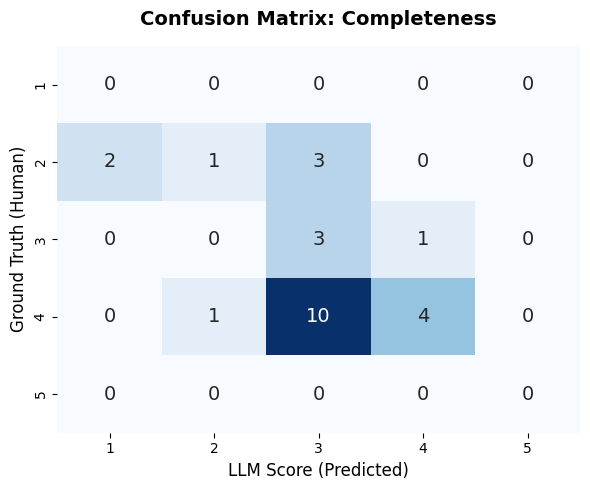

✅ Saved cm_completeness.png


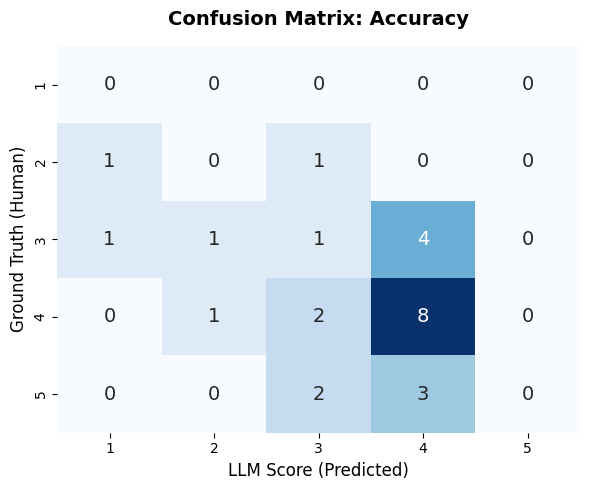

✅ Saved cm_accuracy.png


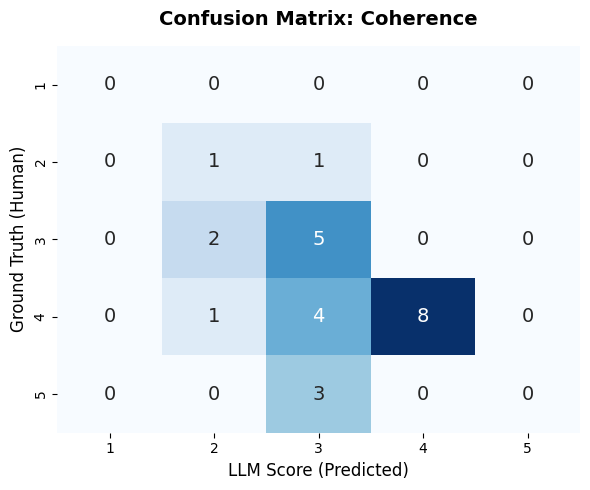

✅ Saved cm_coherence.png


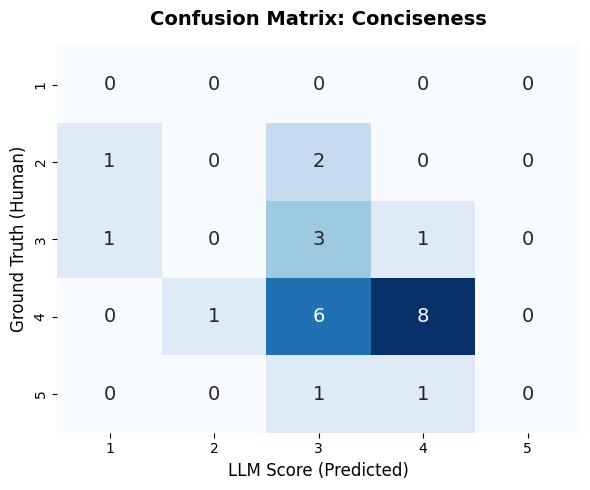

✅ Saved cm_conciseness.png


In [20]:
if 'results_df' in locals() and not results_df.empty:

    dimensions = ['completeness', 'accuracy', 'coherence', 'conciseness']

    print("="*70)
    print("GENERATING CONFUSION MATRICES")
    print("="*70)

    for dim in dimensions:
        # Retrieve data
        llm = results_df[f'{dim}_score']
        gt = results_df[f'gt_{dim}']

        # Create a single figure for this dimension
        plt.figure(figsize=(6, 5))

        # Create confusion matrix (Force 1-5 labels)
        cm = confusion_matrix(gt, llm, labels=[1, 2, 3, 4, 5])

        # Plot Heatmap
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=[1, 2, 3, 4, 5],
                    yticklabels=[1, 2, 3, 4, 5],
                    annot_kws={"size": 14}) # Larger font for numbers

        plt.title(f'Confusion Matrix: {dim.capitalize()}', fontsize=14, fontweight='bold', pad=15)
        plt.xlabel('LLM Score (Predicted)', fontsize=12)
        plt.ylabel('Ground Truth (Human)', fontsize=12)

        # Save individual file
        filename = f'cm_{dim}.png'
        plt.tight_layout()
        plt.savefig(filename, bbox_inches='tight', dpi=150)
        plt.show()

        print(f"✅ Saved {filename}")

else:
    print("⚠️ No data found. Run Cell 9 first.")

### CELL 12: Agreement Rate Visualization

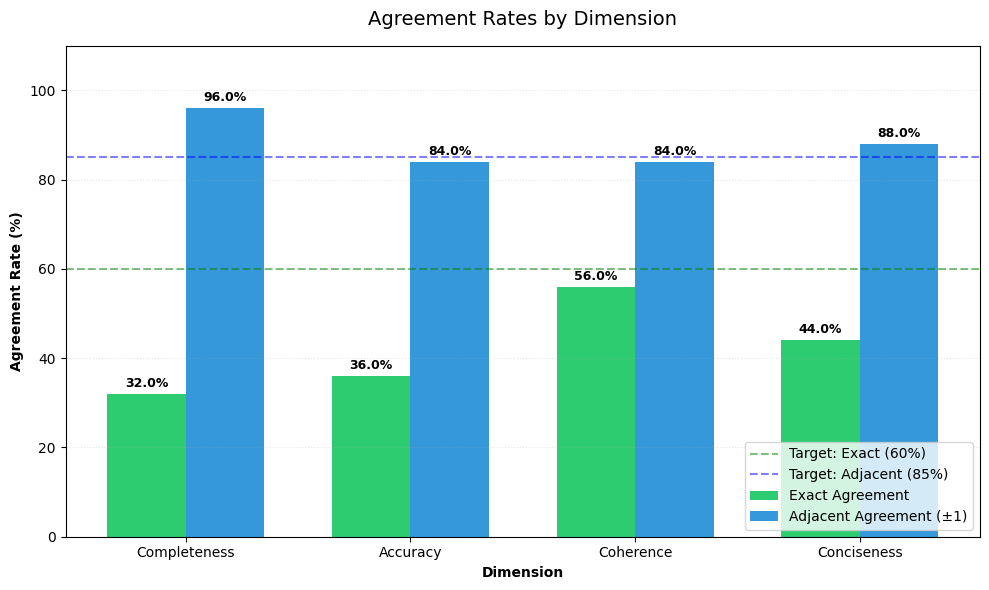

✅ Agreement chart saved to agreement_rates.png


In [21]:
# Ensure we have data
if 'results_df' in locals() and not results_df.empty:

    # 1. Prepare Data (Recalculate directly from DataFrame for safety)
    dimensions = ['completeness', 'accuracy', 'coherence', 'conciseness']
    dim_labels = [d.capitalize() for d in dimensions]

    exact_rates = []
    adjacent_rates = []

    for dim in dimensions:
        llm = results_df[f'{dim}_score']
        gt = results_df[f'gt_{dim}']
        n = len(llm)

        # Calculate rates
        exact_pct = sum(llm == gt) / n * 100
        adj_pct = sum(abs(llm - gt) <= 1) / n * 100

        exact_rates.append(exact_pct)
        adjacent_rates.append(adj_pct)

    # 2. Setup Plot
    x = np.arange(len(dimensions))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))

    # Create Bars
    bars1 = ax.bar(x - width/2, exact_rates, width, label='Exact Agreement', color='#2ecc71')
    bars2 = ax.bar(x + width/2, adjacent_rates, width, label='Adjacent Agreement (±1)', color='#3498db')

    # 3. Add Target Lines (Benchmarks)
    ax.axhline(y=60, color='green', linestyle='--', alpha=0.5, label='Target: Exact (60%)')
    ax.axhline(y=85, color='blue', linestyle='--', alpha=0.5, label='Target: Adjacent (85%)')

    # 4. Styling
    ax.set_xlabel('Dimension', fontweight='bold')
    ax.set_ylabel('Agreement Rate (%)', fontweight='bold')
    ax.set_title('Agreement Rates by Dimension', fontsize=14, pad=15)
    ax.set_xticks(x)
    ax.set_xticklabels(dim_labels)
    ax.set_ylim(0, 110) # Little extra headroom for labels
    ax.legend(loc='lower right')
    ax.grid(axis='y', linestyle=':', alpha=0.3)

    # 5. Add Value Labels
    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.1f}%',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9, fontweight='bold')

    add_labels(bars1)
    add_labels(bars2)

    plt.tight_layout()
    plt.savefig('agreement_rates.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("✅ Agreement chart saved to agreement_rates.png")

else:
    print("⚠️ No data found. Please run Cell 9 to generate results first.")

### CELL 13: Error Analysis - Identify Systematic Patterns

In [22]:
if 'results_df' in locals() and not results_df.empty:
    print("="*70)
    print("ERROR ANALYSIS")
    print("="*70)

    dimensions = ['completeness', 'accuracy', 'coherence', 'conciseness']

    # --- SECTION 1: Bias Analysis ---
    print("\n### Systematic Bias Analysis ###")
    print("(Positive = LLM scores higher, Negative = LLM scores lower)")
    print("-" * 60)

    all_diffs = []

    for dim in dimensions:
        # FIXED: Use correct column names from Cell 9
        llm_col = f'{dim}_score'
        gt_col = f'gt_{dim}'

        llm_vals = results_df[llm_col].values
        gt_vals = results_df[gt_col].values

        # Calculate bias
        diffs = llm_vals - gt_vals
        all_diffs.extend(diffs)

        mean_bias = np.mean(diffs)
        direction = "HIGHER ⬆️" if mean_bias > 0 else "LOWER ⬇️"
        if abs(mean_bias) < 0.1: direction = "NEUTRAL ➖"

        print(f"{dim.capitalize():<15} Mean bias: {mean_bias:>+.2f}  (LLM scores {direction})")

    # Overall bias
    overall_mean = np.mean(all_diffs)
    print("-" * 60)
    print(f"{'OVERALL':<15} Mean bias: {overall_mean:>+.2f}")


    # --- SECTION 2: Worst Disagreements ---
    print("\n\n### Largest Disagreements (|diff| >= 2) ###")
    print("-" * 60)

    disagreements = []
    for idx, row in results_df.iterrows():
        for dim in dimensions:
            llm_col = f'{dim}_score'
            gt_col = f'gt_{dim}'

            val_llm = row[llm_col]
            val_gt = row[gt_col]

            diff = val_llm - val_gt

            if abs(diff) >= 2:
                disagreements.append({
                    'id': row['summary_id'],
                    'dim': dim.capitalize(),
                    'llm': val_llm,
                    'gt': val_gt,
                    'diff': diff
                })

    if disagreements:
        print(f"{'Summary ID':<15} {'Dimension':<15} {'LLM':<8} {'GT':<8} {'Diff':<8}")
        print("-" * 60)
        for d in disagreements:
            print(f"{d['id']:<15} {d['dim']:<15} {d['llm']:<8} {d['gt']:<8} {d['diff']:>+2}")
    else:
        print("✅ Excellent! No major disagreements (>= 2 points) found.")

else:
    print("⚠️ No data found. Please run Cell 9 first.")

ERROR ANALYSIS

### Systematic Bias Analysis ###
(Positive = LLM scores higher, Negative = LLM scores lower)
------------------------------------------------------------
Completeness    Mean bias: -0.40  (LLM scores LOWER ⬇️)
Accuracy        Mean bias: -0.40  (LLM scores LOWER ⬇️)
Coherence       Mean bias: -0.52  (LLM scores LOWER ⬇️)
Conciseness     Mean bias: -0.44  (LLM scores LOWER ⬇️)
------------------------------------------------------------
OVERALL         Mean bias: -0.44


### Largest Disagreements (|diff| >= 2) ###
------------------------------------------------------------
Summary ID      Dimension       LLM      GT       Diff    
------------------------------------------------------------
VAL_01          Accuracy        3        5        -2
VAL_01          Coherence       3        5        -2
VAL_03          Accuracy        2        4        -2
VAL_10          Coherence       3        5        -2
VAL_11          Accuracy        3        5        -2
VAL_11          Cohe

### CELL 14: Save All Results to Google Drive

In [14]:
# 1. Define Output Directory
OUTPUT_DIR = '/content/drive/MyDrive/Courses/2025/3_Fall/EDUC_6192_Large_Language_Model_Applications_in_Education/Project/LLM_Evaluation_Results'

# Ensure the directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"📂 Target Directory: {OUTPUT_DIR}")

if 'results_df' in locals() and not results_df.empty:

    # 2. Setup Filenames
    timestamp = datetime.now().strftime('%Y%m%d_%H%M')
    csv_path = os.path.join(OUTPUT_DIR, f'full_validation_results_{timestamp}.csv')
    json_path = os.path.join(OUTPUT_DIR, f'validation_metrics_{timestamp}.json')

    # 3. Save CSV
    results_df.to_csv(csv_path, index=False)
    print(f"✓ Results CSV saved to: {os.path.basename(csv_path)}")

    # 4. Recalculate Global Metrics (Safety Check)
    dimensions = ['completeness', 'accuracy', 'coherence', 'conciseness']
    all_llm, all_gt = [], []
    dim_stats = {}

    for dim in dimensions:
        llm = results_df[f'{dim}_score'].values
        gt = results_df[f'gt_{dim}'].values
        all_llm.extend(llm)
        all_gt.extend(gt)

        # Calculate dimension specifics
        k = cohen_kappa_score(gt, llm)
        qwk = cohen_kappa_score(gt, llm, weights='quadratic')
        exact = np.sum(llm == gt) / len(llm)

        dim_stats[dim] = {
            'exact_agreement_pct': float(exact * 100),
            'kappa': float(k),
            'qwk': float(qwk)
        }

    # Overall Metrics
    total_n = len(all_llm)
    total_exact = np.sum(np.array(all_llm) == np.array(all_gt))
    total_adjacent = np.sum(np.abs(np.array(all_llm) - np.array(all_gt)) <= 1)

    overall_kappa = cohen_kappa_score(all_gt, all_llm)
    overall_qwk = cohen_kappa_score(all_gt, all_llm, weights='quadratic')

    # 5. Construct JSON
    metrics_summary = {
        'timestamp': timestamp,
        'summary_count': len(results_df),
        'total_score_pairs': total_n,
        'overall_metrics': {
            'exact_agreement_pct': float(total_exact / total_n * 100),
            'adjacent_agreement_pct': float(total_adjacent / total_n * 100),
            'cohens_kappa': float(overall_kappa),
            'quadratic_weighted_kappa': float(overall_qwk)
        },
        'dimension_breakdown': dim_stats,
        'targets_status': {
            'exact_agreement_60pct': bool((total_exact / total_n * 100) >= 60),
            'adjacent_agreement_85pct': bool((total_adjacent / total_n * 100) >= 85),
            'qwk_0.60': bool(overall_qwk >= 0.60)
        }
    }

    # 6. Save JSON
    with open(json_path, 'w') as f:
        json.dump(metrics_summary, f, indent=2)
    print(f"✓ Metrics JSON saved to: {os.path.basename(json_path)}")

    # 7. Copy Images (Updated for split matrices)
    # Now we look for 5 images: 4 separate matrices + 1 agreement chart
    images = [
        'cm_completeness.png',
        'cm_accuracy.png',
        'cm_coherence.png',
        'cm_conciseness.png',
        'agreement_rates.png'
    ]

    print("\nArchiving Images...")
    for img in images:
        if os.path.exists(img):
            dest_path = os.path.join(OUTPUT_DIR, img)
            shutil.copy(img, dest_path)
            print(f"✓ Copied: {img}")
        else:
            print(f"⚠️ Warning: Could not find {img}")

    print("\n✅ All files successfully archived to Google Drive!")

else:
    print("⚠️ No results found to save. Please run Cell 9 first.")

📂 Target Directory: /content/drive/MyDrive/Courses/2025/3_Fall/EDUC_6192_Large_Language_Model_Applications_in_Education/Project/LLM_Evaluation_Results
✓ Results CSV saved to: full_validation_results_20251208_0741.csv
✓ Metrics JSON saved to: validation_metrics_20251208_0741.json

Archiving Images...
✓ Copied: cm_completeness.png
✓ Copied: cm_accuracy.png
✓ Copied: cm_coherence.png
✓ Copied: cm_conciseness.png
✓ Copied: agreement_rates.png

✅ All files successfully archived to Google Drive!


### CELL 15: Print Demo-Ready Summary

In [23]:
if 'results_df' in locals() and not results_df.empty:

    # 1. Recalculate Global Metrics (Ensures safety)
    dimensions = ['completeness', 'accuracy', 'coherence', 'conciseness']
    all_llm, all_gt = [], []

    for dim in dimensions:
        all_llm.extend(results_df[f'{dim}_score'].values)
        all_gt.extend(results_df[f'gt_{dim}'].values)

    all_llm = np.array(all_llm)
    all_gt = np.array(all_gt)

    total_n = len(all_llm)
    total_exact = np.sum(all_llm == all_gt)
    total_adjacent = np.sum(np.abs(all_llm - all_gt) <= 1)

    overall_kappa = cohen_kappa_score(all_gt, all_llm)
    overall_qwk = cohen_kappa_score(all_gt, all_llm, weights='quadratic')

    # Helper for interpretation
    def get_status(value, target):
        return '✓ MET' if value >= target else '✗ FAIL'

    def interpret_score(k):
        if k < 0.4: return "Poor/Fair"
        elif k < 0.6: return "Moderate"
        elif k < 0.8: return "Good"
        return "Excellent"

    # 2. Print The Report
    print("="*70)
    print("VALIDATION SUMMARY - DEMO READY")
    print("="*70)

    print(f"""
📊 AUTOMATED SUMMARY EVALUATION SYSTEM - VALIDATION RESULTS

Model: Meta Llama 3.1 8B (4-bit quantized)
Validation Set: {len(results_df)} student summaries
Total Score Comparisons: {total_n}

┌────────────────────────────────────────────────────┐
│                 KEY METRICS                        │
├─────────────────────┬──────────┬──────────┬────────┤
│ Metric              │ Result   │ Target   │ Status │
├─────────────────────┼──────────┼──────────┼────────┤
│ Exact Agreement     │ {total_exact/total_n*100:>5.1f}%   │ ≥60%     │ {get_status(total_exact/total_n*100, 60):>6} │
│ Adjacent Agreement  │ {total_adjacent/total_n*100:>5.1f}%   │ ≥85%     │ {get_status(total_adjacent/total_n*100, 85):>6} │
│ Cohen's Kappa       │ {overall_kappa:>5.3f}    │ ≥0.65    │ {get_status(overall_kappa, 0.65):>6} │
│ QWK (Quadratic)     │ {overall_qwk:>5.3f}    │ ≥0.60    │ {get_status(overall_qwk, 0.60):>6} │
└─────────────────────┴──────────┴──────────┴────────┘

Interpretation:
- Exact agreement of {total_exact/total_n*100:.1f}% means the LLM matched expert scores exactly
  in {total_exact} out of {total_n} score comparisons.
- Adjacent agreement of {total_adjacent/total_n*100:.1f}% means scores were within ±1 point
  in {total_adjacent} out of {total_n} comparisons.
- QWK of {overall_qwk:.3f} indicates {interpret_score(overall_qwk).upper()} agreement
  between the AI and Human graders.
""")

else:
    print("⚠️ No results found. Please run Cell 9 first.")

VALIDATION SUMMARY - DEMO READY

📊 AUTOMATED SUMMARY EVALUATION SYSTEM - VALIDATION RESULTS

Model: Meta Llama 3.1 8B (4-bit quantized)
Validation Set: 25 student summaries
Total Score Comparisons: 100

┌────────────────────────────────────────────────────┐
│                 KEY METRICS                        │
├─────────────────────┬──────────┬──────────┬────────┤
│ Metric              │ Result   │ Target   │ Status │
├─────────────────────┼──────────┼──────────┼────────┤
│ Exact Agreement     │  42.0%   │ ≥60%     │ ✗ FAIL │
│ Adjacent Agreement  │  88.0%   │ ≥85%     │  ✓ MET │
│ Cohen's Kappa       │ 0.141    │ ≥0.65    │ ✗ FAIL │
│ QWK (Quadratic)     │ 0.402    │ ≥0.60    │ ✗ FAIL │
└─────────────────────┴──────────┴──────────┴────────┘

Interpretation:
- Exact agreement of 42.0% means the LLM matched expert scores exactly 
  in 42 out of 100 score comparisons.
- Adjacent agreement of 88.0% means scores were within ±1 point 
  in 88 out of 100 comparisons.
- QWK of 0.402 indicate